## CÓDIGO PARA ENCONTRAR LOS DIÁMETROS DE LOS OBJETOS PUNTUALES DE UNA IMAGEN FITS

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
from photutils.psf import extract_stars
from astropy.nddata import NDData
from astropy.table import Table
from astropy.table import QTable
from astropy.stats import  mad_std
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import warnings
from photutils.psf import PSFPhotometry
from photutils.psf import IntegratedGaussianPRF
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [23]:
# Open FITS file con astrometria
#file_path = "/Users/alejandralemus/Documents/diciembre 20 2024/Filtro B/Img_corr_B/SUM_Astro_Filter_B.fits"  # Reemplaza con la ruta a tu archivo FITS
#file_path = "/Users/alejandralemus/Documents/diciembre 20 2024/Filtro V/Img_corr_V/SUM_Aligned_Stack_Filter_V.fits"  # Reemplaza con la ruta a tu archivo FITS
#file_path = "/Users/alejandralemus/Documents/diciembre 20 2024/Filtro R/Img_corr_R/SUM_Aligned_Stack_Filter_R.fits"  # Reemplaza con la ruta a tu archivo FITS
#file_path = "/Users/alejandralemus/Documents/diciembre 20 2024/Filtro I/Img_corr_I/SUM_Aligned_Stack_Filter_I.fits"  # Reemplaza con la ruta a tu archivo FITS
file_path = "/Users/alejandralemus/Documents/diciembre 20 2024/Clear/Img_corr_CLear/SUM_Aligned_Stack_Filter_Clear.fits"  # Reemplaza con la ruta a tu archivo FITS
star_square_size = 9

Procesando archivo: /Users/alejandralemus/Documents/diciembre 20 2024/Clear/Img_corr_CLear/SUM_Aligned_Stack_Filter_Clear.fits
21555.0 283.17702373457
se encontraron 53 estrellas en total


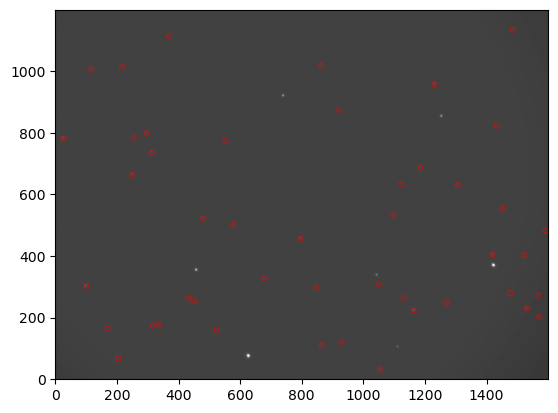

Se procesaron: 46 estrellas
....
No se pudieron determinar los radios de 27


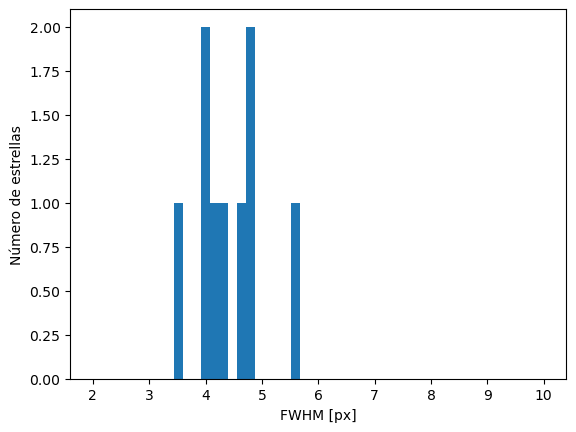

[3.56230447 3.93817256 4.07771032 4.1400744  4.37485846 4.63650036
 4.7506571  4.77452103 5.59770292        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
Los parámetros estadísticos de los diámetros encontrados para 46 estrellas  son:
....
Promedio: 4.428
....
Mediana: 4.375
....
Desviación estandar: 0.561


In [24]:
def find_star(file_path, saturation_level=65000):
    print(f"Procesando archivo: {file_path}")

    # Cargar los datos de la imagen FITS
    hdul = fits.open(file_path)
    image_data = hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)  

    # Calcular la desviación estándar (ruido de fondo) de la imagen
    std, median = mad_std(image_data), np.median(image_data)
    print(median, std)
    
    # Detectar estrellas utilizando DAOStarFinder
    # Ajusta el valor del FWHM (FWHM de la PSF estimada) y el threshold (umbral de detección)
    daofind = DAOStarFinder(fwhm=6.0, threshold=6*std)
    stars = daofind(image_data- median)

    if stars is None:
        print("No se encontraron estrellas.")
        return None
    print(f"se encontraron {len(stars)} estrellas en total")

    # Coordenadas de las estrellas
    x_coords = stars["xcentroid"]
    y_coords = stars["ycentroid"]
    
    #Excluir estrellas saturadas
    non_saturated_indices = image_data[y_coords.astype(int), x_coords.astype(int)] < saturation_level
    x_coords = x_coords[non_saturated_indices]
    y_coords = y_coords[non_saturated_indices]

    # Visualización de las estrellas encontradas
    positions = np.transpose((x_coords, y_coords))  # Coordenadas de las estrellasapertures = CircularAperture(positions, r=8.0)
    #positions = np.transpose((stars["xcentroid"], stars["ycentroid"]))# coordenadas de las estrellas
    apertures = CircularAperture(positions, r=8.0)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image_data, cmap="gray", origin="lower", norm=norm)
    apertures.plot(color="red", lw=1, alpha=0.5);
    plt.show()

    return x_coords, y_coords,image_data-median

x, y, image_data = find_star(file_path)
stars_find = QTable([x, y], names=('x', 'y'))

psf_model = IntegratedGaussianPRF(flux=1, sigma=5.0 / 2.35)
fit_shape = (21, 21)
#finder = DAOStarFinder(6.0, 2.0)
#psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=4)
psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=4)

init_params = QTable()

init_params['x'] = x

init_params['y'] = y

original_image = image_data.copy()

phot = psfphot(image_data, init_params=stars_find)

def minmax(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)

stars_tbl = Table()

stars_tbl['x'] = phot["x_fit"]

stars_tbl['y'] = phot["y_fit"]  

mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.0)  
image_data = image_data.astype(np.float64) - median_val  
field_data = NDData(image_data)

psf_image = psfphot.make_model_image(image_data.shape)
ns_psf_image = np.sqrt(minmax(psf_image))
psf_field_data = NDData(psf_image)

stars = extract_stars(field_data, stars_tbl, size=star_square_size)

def fxn():  # Nos aseguramos de que los valores menores a 1 y mayores a 50 sean NaN
    x_fwhm = []
    y_fwhm = []
    radii = []
    for i in range(len(stars)):
        z = np.array(stars[i])
        y, x = np.mgrid[:z.shape[0], :z.shape[1]]
        
        p_init = models.Gaussian2D()
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='Model is linear in parameters', category=AstropyUserWarning)
            #p = fit_p(p_init, x, y, z)

        # Intentar ajustar el modelo
            try:
                p = fit_p(p_init, x, y, z)
            except Exception as e:
                print(f"Error al ajustar la estrella {i}: {e}")
                x_fwhm.append(np.nan)
                y_fwhm.append(np.nan)
                radii.append(np.nan)
                continue  # Salta a la siguiente estrella
        
        # Extrae los valores ajustados de FWHM
        x_fwhm_val = p.x_fwhm if p.x_fwhm >= 1 and p.x_fwhm <= 50 else np.nan
        y_fwhm_val = p.y_fwhm if p.y_fwhm >= 1 and p.y_fwhm <= 50 else np.nan
        
        # Guardar los valores en las listas o reemplazar con NaN
        x_fwhm.append(x_fwhm_val)
        y_fwhm.append(y_fwhm_val)
        
        # Agrega a radii el menor de x_fwhm_val o y_fwhm_val si cumplen la condición
        if np.isnan(x_fwhm_val) or np.isnan(y_fwhm_val):
            radii.append(np.nan)
        else:
            radii.append(min(x_fwhm_val, y_fwhm_val))
    
    # Convierte las listas a arrays de NumPy
    x_fwhm = np.array(x_fwhm, dtype=np.float64)
    y_fwhm = np.array(y_fwhm, dtype=np.float64)
    radii = np.array(radii, dtype=np.float64)
    
    x_star = stars.center_flat[:, 0]
    y_star = stars.center_flat[:, 1]

    return x_star, y_star, x_fwhm, y_fwhm, radii


#with warnings.catch_warnings(action="ignore"):
x_star, y_star, x_fwhm, y_fwhm, radii = fxn()

print(f"Se procesaron: {len(x_star)} estrellas")
print("....")
nan = np.sum(np.isnan(x_fwhm))
print(f"No se pudieron determinar los radios de {nan}")

plt.hist(radii, bins=50, range=(2.0,10.0))
plt.xlabel("FWHM [px]")
plt.ylabel("Número de estrellas")
plt.show()
print(np.sort(radii))

from astropy.stats import mad_std

filtered_radii = radii[(radii > 1)]

# Calcular la media, mediana y desviación estándar para los valores filtrados
mean_d, median_d, std_d = np.nanmean(filtered_radii), np.nanmedian(filtered_radii), np.nanstd(filtered_radii)



print(f"Los parámetros estadísticos de los diámetros encontrados para {len(radii)} estrellas  son:")
print("....")
print(f"Promedio: {mean_d:.3f}")
print("....")
print(f"Mediana: {median_d:.3f}")
print("....")
print(f"Desviación estandar: {std_d:.3f}")